## **EXPLORATORY DATA ANALYSIS** 
**EXP 03. TIME SERIES DECOMPOSITION CLUSTERING** <br>
*ARGENTINIAN MAIZE INTERNATIONAL TRADE*

**DISCLAIMER:** <br>
*The data used for analyzing the market was obtained from the United Nations Stats and other open sources and the present project only has non-profit meanings, has been developed just to show analytic skills as part of a personal project portfolio so, the information and insights in the present document can't be used with commercial purposes keeping each data source with their original licences.*

**INTRODUCTION:** <br>
It is usual to find time series problems when we are working in business areas, those can be series about sales, stock levels, product demands or even data about machinery failures and maintenance. This kind of problem is used to be defined with high dimensional characteristics due to the granularity level that business requires and the main way to work with used to be aggregating the dataset with particular business metrics in a determined time period which misses part of the information contained in the dataset regarding the characteristics of the time series itself and about the relationships between the values among the timestamps, one clear example could be that you can lose information about the seasonality behaviour and the patterns among the analyzed dimensions.

Clustering algorithms as part of an Exploratory Data Analysis are powerful tools to identify hidden patterns in data and when working with time series we can take two approaches, the most frequent in my experience (and not necessarily the best) is the above-mentioned, aggregating the dataset but, we can bring to the analysis the time series characteristics using the proper techniques.
In this project, we are going to explore three clustering alternatives to work with time series using a dataset with the Argentinian Maize Exports by partner country:
* Aggregating the dataset and working with basic business metrics
* Working with the Dynamic Time Warping over the target variable time series
* Decomposing the time series into its three components *(current notebook)*


**OBJECTIVE:** <br>
Identify hidden patterns in data using the Time series components and an Clustering technique over the trade partners


**PIPELINE:** <br>
* Dataset transformation into a classification problem.
* Dataset preprocessing.
* Optimal number of clusters definitions.
* Partners clustering experiments and clusters definitions.


### 00.00. RESOURCES AND WORK ENVIRONMENT SETTING

To develop this projects, we need to prepare the environment and that involves loading the required libraries and to defined the work directory where:

**Data Handling Libraries:**
* **pandas:** working with dataframes
* **numpy:** handling numbers

**Graphic Libraries:**
* **matplotlib:** creating graphic objects
* **seaborn:** creating graphic objects

**Clustering Resources:**
* **sklearn:** Machine Learning library, used to data preprocessing and also for clustering creation and definition
* **fastdtw:** Dynamic Time Warping implementation
* **seasonal_decompose**: Time Series Decomposition

**General Config Libraries:**
* **os:** workdirectory path definition
* **warnings:** ignore warnings messages from libraries

#### 00.01. LIBRARIES AND WD

In [1]:
##-- ENVIRONMENT SETTINGS
import pandas as pd ; from pandas.tseries.offsets import MonthEnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
##-- GENERAL SETTINGS
csvAttr_imp = {'sep': ';' , 'encoding': 'UTF-8'} #csv settings - export

cereal = 'Maize'
maxClusterNumbers = 6
randomStateValue = 2023
flowType = 'export'

flowColumn = 't_exp' if flowType.lower() == 'export' else 't_imp'
flowColumnInv = 't_imp' if flowType.lower() == 'export' else 't_exp'

In [3]:
##-- WORK DIRECTORY
wd = 'C:/Users/jrab9/OneDrive/08.Github/2023.HS10-ARG.Clustering/01.Data/'

os.chdir(wd)

In [4]:
##-- AD-HOC FUNCTIONS
def tsDecomposition(df_base, cereal, flowType): #To transform the main serie in 3 new dataframes with each component    
    #flowColumn = 't_exp' if flowType.lower() == 'export' else 't_imp'
    
    workPaper = df_base[df_base['desc_l2'] == cereal].reset_index(drop = True).copy()[['date','partnerCodeISO',flowColumn]]  
    
    partnerCodes = workPaper.partnerCodeISO.unique()
    
    df_trend = pd.DataFrame()
    df_seasonal = pd.DataFrame()
    df_residual = pd.DataFrame() 
    
    for partner in partnerCodes:
        df_temp = workPaper[workPaper['partnerCodeISO'] == partner]        
        
        #-SCALING
        scaler = StandardScaler()    
        df_temp[flowColumn] = scaler.fit_transform(df_temp[flowColumn].values.reshape(-1,1))

        ##INDEX
        df_temp.set_index(pd.to_datetime(df_temp['date'], format = '%Y-%m-%d'), inplace = True)
        df_temp = df_temp.asfreq('m')
        
        #-TIME SERIE DECOMPOSITION
        sdModel = 'additive'
        sdDF = seasonal_decompose(df_temp[flowColumn], model = sdModel)

        clusteredData = pd.DataFrame({'trend': sdDF.trend,
                                      'seasonal': sdDF.seasonal,
                                      'residual': sdDF.resid
                                     })

        df_temp_trend = clusteredData.trend.T
        df_temp_trend['partnerCodeISO'] = partner
        df_temp_trend['flowType'] = flowType
        df_temp_trend['component'] = 'trend'

        df_temp_seasonal = clusteredData.seasonal.T
        df_temp_seasonal['partnerCodeISO'] = partner
        df_temp_seasonal['flowType'] = flowType
        df_temp_seasonal['component'] = 'seasonal'

        df_temp_resid = clusteredData.residual.T
        df_temp_resid['partnerCodeISO'] = partner
        df_temp_resid['flowType'] = flowType
        df_temp_resid['component'] = 'residual'    

        df_temp_trend['cereal'] = cereal  
        df_temp_seasonal['cereal'] = cereal 
        df_temp_resid['cereal'] = cereal  

        df_trend = df_trend.append(df_temp_trend)
        df_seasonal = df_seasonal.append(df_temp_seasonal)
        df_residual = df_residual.append(df_temp_resid)     

        del(df_temp_trend,df_temp_seasonal,df_temp_resid,sdDF,clusteredData, scaler)   
        print(f'{flowType} of {cereal} done for partner {partner}', end = '\r')                   
          
    df_trend.set_index(df_trend.partnerCodeISO, inplace = True) ; df_seasonal.set_index(df_seasonal.partnerCodeISO, inplace = True) ; df_residual.set_index(df_residual.partnerCodeISO, inplace = True)
    df_trend.columns.name = None ; df_seasonal.columns.name = None ; df_residual.columns.name = None  
    
    df_timeSeriesDecomp = df_trend.drop(columns = ['cereal']).melt(id_vars = ['partnerCodeISO','flowType','component'], var_name = 'date')
    df_timeSeriesDecomp = df_timeSeriesDecomp.append(df_seasonal.drop(columns = ['cereal']).melt(id_vars = ['partnerCodeISO','flowType','component'], var_name = 'date'))
    df_timeSeriesDecomp = df_timeSeriesDecomp.append(df_residual.drop(columns = ['cereal']).melt(id_vars = ['partnerCodeISO','flowType','component'], var_name = 'date'))
    df_timeSeriesDecomp

    print(f'process ended, df_trend: {df_trend.shape}, df_seasonal: {df_seasonal.shape}, df_residual: {df_residual.shape}, df_timeSeriesDecomp: {df_timeSeriesDecomp.shape}')

    return df_trend, df_seasonal, df_residual, df_timeSeriesDecomp

def grxClusters(df, target, flowType, clusterIndex = 0, scaled = False, MinMax = True):     
    colPrefix = f'{optimalNumberOfClusters[clusterIndex]}_clusters{target.title()}'
    #flowColumn = 't_exp' if flowType.lower() == 'export' else 't_imp'
    
    numberOfClustersToPlot = optimalNumberOfClusters[clusterIndex]
    numberOfCols = 4 if numberOfClustersToPlot >= 4 else int(numberOfClustersToPlot)
    numberOfRows = int(np.ceil(numberOfClustersToPlot / numberOfCols))

    figShapeHeight = numberOfRows * 4
    figShapeWidth = numberOfCols * 6
    
    df = df.reset_index(drop = False).fillna(0)
    
    if scaled: #Scaling each country series, not all the dataset
        df_scaled = pd.DataFrame()
        for partner in partnerCodes:
            df_partner_temp = df[df['partnerCodeISO'] == partner].reset_index(drop = True)
            
            #-SEPARING NUMERIC AND CATEGORIC VARS
            numCols = [flowColumn]
            catCols = df_partner_temp.columns[df_partner_temp.columns != flowColumn]

            #-SEPARATING DATA
            df_tempNum = df_partner_temp[numCols] ; df_tempCat = df_partner_temp[catCols]
            #-SCALING
            if MinMax == True:
                scaler = MinMaxScaler()  
            else:
                scaler = StandardScaler()        
            scaledData = scaler.fit_transform(df_tempNum)

            #-SCALED DATA
            df_partner_temp_scaled = pd.DataFrame(scaledData, columns=numCols)
            df_partner_temp = pd.concat([df_partner_temp_scaled, df_tempCat], axis=1) 
            
            df_scaled = df_scaled.append(df_partner_temp)
            
        df = df_scaled.copy().fillna(0) ; del(df_scaled)         
        
    if scaled:
        if MinMax:
            titleExtension = 'each series (individually) scaled by MinMax Normalization'
        else:
            titleExtension = 'each series (individually) scaled by Z-Score'
    else:
        titleExtension = 'units of cereal in thousand tonnes'
        
    #-MEANS BY CLUSTER
    df_clustersMeans = pd.DataFrame({'date':df['date']}).drop_duplicates()  
       
    for clusterId in range(numberOfClustersToPlot):
        clusterName = f'c{clusterId}'
        df_cluster = df[df[f'{colPrefix}'] == clusterId].groupby('date').agg(var=(flowColumn, 'mean')).reset_index().rename(columns={'var': clusterName})
        if scaled == False:         
            df_cluster[clusterName] = df_cluster[clusterName] / 1000
        df_clustersMeans = df_clustersMeans.merge(df_cluster[['date', clusterName]], on='date', how='left')
        
    df_clustersMeans = df_clustersMeans.sort_values('date', ascending = True).set_index('date').dropna()
    
    #-FIGURE CONFIG
    fig, axes = plt.subplots(nrows=numberOfRows, ncols=numberOfCols, sharey=False, sharex=False, figsize=(figShapeWidth, figShapeHeight))
    fig.suptitle(f'K-means: {flowType.capitalize()}s of {cereal} Time Series Clusterized by {target} Component in {numberOfClustersToPlot} Clusters\n{titleExtension}')

    #-ITERATING OVER CLUSTERS
    for clusterID, ax in zip(range(numberOfClustersToPlot), axes.flatten()):
        clusterName = f'c{clusterID}'        
       
        ##-CLUSTER DATA
        for partner in partnerCodes:
            df_temp = df[(df[f'{colPrefix}'] == clusterID) & (df['partnerCodeISO'] == partner)][['date', flowColumn]].sort_values('date', ascending = True).set_index('date').dropna()
            if scaled == False:      
                df_temp[flowColumn] = df_temp[flowColumn] / 1000
            ax.plot(df_temp[flowColumn])
        
        #-CLUSTER MEANS ----------
        ax.plot(df_clustersMeans[clusterName], linestyle='--', color='black')
        ax.set_title(f'Cluster {clusterName}', y = -0.2)
            
    return fig

def grxClusters_stdDecomp(df, target, flowType, clusterIndex = 0):  
    colPrefix = f'{optimalNumberOfClusters[clusterIndex]}_clusters{target.title()}'
    
    df = df[df['flowType'] == flowType].reset_index(drop = False)
    
    numberOfClustersToPlot = optimalNumberOfClusters[clusterIndex]
    numberOfCols = 4 if numberOfClustersToPlot >= 4 else int(numberOfClustersToPlot)
    numberOfRows = int(np.ceil(numberOfClustersToPlot / numberOfCols))

    figShapeHeight = numberOfRows * 4
    figShapeWidth = numberOfCols * 6
    
    #-MEANS BY CLUSTER
    #**** #####---DEPRECATED: The following will calculate the average value among series,we want to show the centroid value of each cluster
    #**** #df_clustersMeans = pd.DataFrame({'date':df['date']}).drop_duplicates()  
       
    #**** #for clusterId in range(numberOfClustersToPlot):
    #**** #    clusterName = f'c{clusterId}'
    #**** #    df_cluster = df[df[f'{colPrefix}'] == clusterId].groupby('date').agg(var=('value', 'mean')).reset_index().rename(columns={'var': clusterName})
    #**** #    df_clustersMeans = df_clustersMeans.merge(df_cluster[['date', clusterName]], on='date', how='left')
        
    #**** #df_clustersMeans = df_clustersMeans.sort_values('date', ascending = True).set_index('date').dropna()
    
    #Here we are taking the centroid value
    df_clustersMeans = kmeansCenters[kmeansCenters['exp'] == newColumns[clusterIndex]].reset_index(drop = True).drop(columns = 'partners').melt(id_vars = ['cluster','exp']).sort_values('variable').rename(columns = {'variable':'date','value':flowColumn})
    
    #-FIGURE CONFIG
    fig, axes = plt.subplots(nrows=numberOfRows, ncols=numberOfCols, sharey=False, sharex=False, figsize=(figShapeWidth, figShapeHeight))
    fig.suptitle(f'K-means: {flowType.capitalize()}s of {cereal} Time Series Clusterized by {target} Component in {numberOfClustersToPlot} Clusters\nSeries Scaled by Z-Score')

    #-ITERATING OVER CLUSTERS
    for clusterID, ax in zip(range(numberOfClustersToPlot), axes.flatten()):
        clusterName = f'c{clusterID}'        
       
        ##-CLUSTER DATA
        for partner in partnerCodes:
            df_temp = df[(df[f'{colPrefix}'] == clusterID) & (df['partnerCodeISO'] == partner)][['date', 'value']].sort_values('date', ascending = True).set_index('date').dropna()
            ax.plot(df_temp['value'])
        
        #-CLUSTER MEANS 
        #**** #ax.plot(df_clustersMeans[clusterName], linestyle='--', color='black')
        ax.plot(df_clustersMeans[df_clustersMeans['cluster'] == clusterID][['date',flowColumn]].reset_index(drop = True).sort_values('date',ascending = True).set_index('date').fillna(0), linestyle='--', color='black')
        ax.set_title(f'{clusterName}',y = -0.2)
            
    return fig

#### 00.02 DATA

The dataset has been cleaned and curated for this problem in the file etl.py and it contains data for all partners in every single timestamp, for those months with no transactions the variables numeric will take 0 as value and it doesn’t contain any Null value.

In [5]:
##-- DATA
colsToKeep = ['calendarCode','date',flowColumn,'reporterCodeISO','reporterDesc','partnerCodeISO','partnerDesc','partnerRegionDesc','desc_l2']

df_base = pd.read_csv(wd + '/dfM.csv.gz', sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_base['date'] = pd.to_datetime(df_base['date'], format = '%Y-%m-%d')

In [6]:
##-- DATA
colsToKeep = ['calendarCode','date',flowColumn,'reporterCodeISO','reporterDesc','partnerCodeISO','partnerDesc','partnerRegionDesc','desc_l2']

df_base = pd.read_csv(wd + '/dfM.csv.gz', sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_base['date'] = pd.to_datetime(df_base['date'], format = '%Y-%m-%d')

df_base_copy = df_base[np.append(colsToKeep,flowColumnInv)].copy()

df_base = df_base[colsToKeep]

##-- DATASET FACTS
dfShape = df_base.shape
dfMinDate = df_base.date.min().date()
dfMaxDate = df_base.date.max().date()
dfMonths = len(pd.date_range(dfMinDate,dfMaxDate, freq = 'm'))

print(f'Data Frame shape: {dfShape}')
print(f'Time series range from {dfMinDate} to {dfMaxDate} ({dfMonths} meses)')

Data Frame shape: (74752, 9)
Time series range from 2016-12-31 to 2022-12-31 (73 meses)


The dataset contains 74752 rows (observations), each representing one cereal and partner transaction in one month between the above-printed range, and it can be statistically described as follows, at this point this data wont be useful due that we have many cereals and partners time series appended:

In [7]:
##-- NUMERIC COLUMNS RELATED TO EXPORTS
df_base[flowColumn].describe()

count    7.475200e+04
mean     4.252870e+03
std      4.530350e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.326720e+06
Name: t_exp, dtype: float64

In [8]:
##-- CATEGORICAL & DT VARIABLES
df_base[df_base.columns[df_base.columns != flowColumn]].drop(columns = 'calendarCode').describe()

,date,reporterCodeISO,reporterDesc,partnerCodeISO,partnerDesc,partnerRegionDesc,desc_l2
count,74752,74752,74752,74752,74752,74752,74752
unique,73,1,1,128,128,6,8
top,2016-12-31 00:00:00,ARG,Argentina,BDI,Burundi,Africa,Wheat
freq,1024,74752,74752,584,584,21608,9344
first,2016-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


### 01.00. TRANSFORMATIONS AND PREPROCESSING

In the current state, the dataset is not ready for clustering, now we have many time series appended in rows, and we need to prepare the dataset to be used in a classification problem, for this the timestamps will be pivoted, to Each time series will be presented in a single row for each partner.

The main steps behind the transformation process are:
1. To pivot the dataset through its timestamps, getting one partner trade time series in each row.
2. To escalate the dataset using Z-score technique
3. Extracting each time series component trend, seasonal and residual (or random) components

*Observations:* Only the countries with transactions during the last year (2022 in the dataset) will be considered to the analysis.


In [9]:
##-FILTERING DF: ONLY CEREAL OF INTEREST
df_base = df_base[df_base['desc_l2'] == cereal].reset_index(drop = True).copy()

##-FILTERING DF: ONLY PARTNERS WITH COMMERCE IN THE LAST YEAR
flowColumn = 't_exp' if flowType.lower() == 'export' else 't_imp'

partnersOfInterest = df_base[['partnerCodeISO',flowColumn,'date']][df_base['date'].dt.year == df_base['date'].dt.year.max()].groupby(['partnerCodeISO']).agg(val = (flowColumn,'sum')).reset_index()
partnersOfInterest = partnersOfInterest[partnersOfInterest['val'] != 0].reset_index(drop = True)['partnerCodeISO']
partnersOfInterest

df_base = df_base[df_base['partnerCodeISO'].isin(partnersOfInterest)].reset_index(drop = True).copy()
df_base.shape

(4088, 9)

In [10]:
df_base.desc_l2.unique()

array(['Maize'], dtype=object)

**Preprocessing and Transformation:**

The transformation and preprocessing have been consolidated into the function “tsDecomposition“ where each partner series have been standardized individually.

The result of the function is a dataset for each component and a consolidated dataset to plot in one of the following sections.

In [11]:
df_trend, df_seasonal, df_residual, df_timeSeriesDecomp = tsDecomposition(df_base = df_base, cereal = cereal, flowType = flowType)

process ended, df_trend: (56, 77), df_seasonal: (56, 77), df_residual: (56, 77), df_timeSeriesDecomp: (12264, 5)


### 02.00. CLUSTERING BY TREND COMPONENT
#### 02.01. OPTIMAL NUMBER OF CLUSTERS

For this exercise, the k-means algorithm has been selected due to its interpretability (centroid means) and to the nature of the problem (unsupervised). Before creating the clusters, we need to answer a particular question: how many clusters do we need? this question could has multiple answers, and it depends on two main issues:
* Is there any need for the business? for example, this can be a determined number of clusters for a particular campaign. 
* If we don’t have any constraints or requirements, we can work supported with clustering quality metrics, visual analysis and considering business knowledge (this is a key piece to delivering better quality solutions)

To determine the optimal number of clustering we are going to use three metrics:
1. *Silhouette coefficient:* This coefficient considers the mean intra-cluster distance (cohesion) and the mean nearest-cluster distance (separation) for each sample and takes values between -1 and 1 where the highest values indicate better matches to its cluster.
2. *Calinski Harabasz Score:* This score is calculated considering the ratio of between-cluster dispersion and of within-cluster dispersion. The highest values indicate a better definition of the cluster.
3. *Davies Bouldin Index:* This index measures the average similarity between clusters comparing the distances between clusters with the size of the cluster. The lowest value possible is Zero and the closer the value to zero means a better cluster partition.

For further information, https://scikit-learn.org/stable/modules/clustering.html presents a good summary of clustering concepts.




In [12]:
##-- OPTIMAL CLUSTER NUMBERS
target = 'trend'

if target == 'trend':
    df_temp = df_trend.copy()
elif target == 'seasonal':
    df_temp = df_seasonal.copy()
elif target == 'residual':
    df_temp = df_residual.copy()
    
numberOfClusters = pd.DataFrame()    
X = df_temp.drop(columns = ['partnerCodeISO', 'flowType','component', 'cereal']).fillna(0)        

for clusters in range(2,maxClusterNumbers + 1):
    kmeans = KMeans(n_clusters = clusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_

    score_s = silhouette_score(X, labels)
    score_c = calinski_harabasz_score(X, labels)
    score_d = davies_bouldin_score(X, labels)

    numberOfClusters = numberOfClusters.append({'cereal': cereal,
                                                'clusters': clusters,
                                                'silhouetteScore': score_s,
                                                'calinskiHarabaszScore': score_c,
                                                'daviesBouldinScore': score_d,
                                                'flowType':flowType
                                                }, ignore_index = True) 
    
numberOfClusters['maxValueOf_S'] = numberOfClusters['silhouetteScore'] == numberOfClusters['silhouetteScore'].max()
numberOfClusters['maxValueOf_C'] = numberOfClusters['calinskiHarabaszScore'] == numberOfClusters['calinskiHarabaszScore'].max()
numberOfClusters['minValueOf_D'] = numberOfClusters['daviesBouldinScore'] == numberOfClusters['daviesBouldinScore'].min()

del(df_temp)     
    
optimalNumberOfClusters = numberOfClusters[(numberOfClusters['maxValueOf_S']) | (numberOfClusters['maxValueOf_C']) | (numberOfClusters['minValueOf_D'])].reset_index(drop = True)
optimalNumberOfClusters = optimalNumberOfClusters.clusters.unique()
optimalNumberOfClusters

array([2, 3], dtype=int64)

Each metric suggests a different number of optimal clusters (limited to 6 possible clustersas the max number of clusters tested in the present project).

|**METRIC**             | **#CLUSTERS**|
|-----------------------|--------------|
|Silohuette Index       | 2 Clusters |
|Calinski Harabasz Score| 3 Clusters |
|Davies-Bouldin Index   | 3 Clusters |

#### 02.02. CLUSTERING BY K-MEANS
The K-means algorithm has been selected due to its interpretability; each cluster has a centroid with the mean value for each evaluated variable.

In [13]:
##-- DATA (X)
if target == 'trend':
    df_temp = df_trend.copy()
elif target == 'seasonal':
    df_temp = df_seasonal.copy()
elif target == 'residual':
    df_temp = df_residual.copy()
    
X = df_temp.drop(columns = ['partnerCodeISO', 'flowType','component', 'cereal']).fillna(0)   

##-- RESOURCES
partnerCodes = df_base.partnerCodeISO.unique()

In [14]:
##--CLUSTERING
Y = X.copy().reset_index()
newColumns = []
kmeansCenters = pd.DataFrame()

for numClusters in optimalNumberOfClusters:
    clusterTag = f'{numClusters}_clusters{target.title()}'
    
    kmeans = KMeans(n_clusters = numClusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_
    centers = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
    centers['cluster'] = centers.index
    centers['exp'] = clusterTag           
    
    Y[clusterTag] = labels
    centers['partners'] = Y.groupby(clusterTag).size().values ##-PARTNERS BY CLUSTERS
    
    kmeansCenters = kmeansCenters.append(centers).reset_index(drop = True)
    newColumns = np.append(newColumns,clusterTag)
    
    df_base = df_base.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
    df_timeSeriesDecomp = df_timeSeriesDecomp.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
                                  
newColumns

array(['2_clustersTrend', '3_clustersTrend'], dtype='<U32')

#### 02.03 SERIES COMPARISON

Once the optimal number of clusters to test has been determined it's time to evaluate the results, in this case, we don't have multiple variables to plot in a radar chart for analyzing the characteristics of each cluster so, we can compare distirbutions and series to observe if the shapes and characteristcs of a cluster are similar.

For this analysis, the series will be plotted by cluster standardized and with each cluster centroid for a better comprehension of the cluster pattern and behaviour.

,0,1
partners,25,31


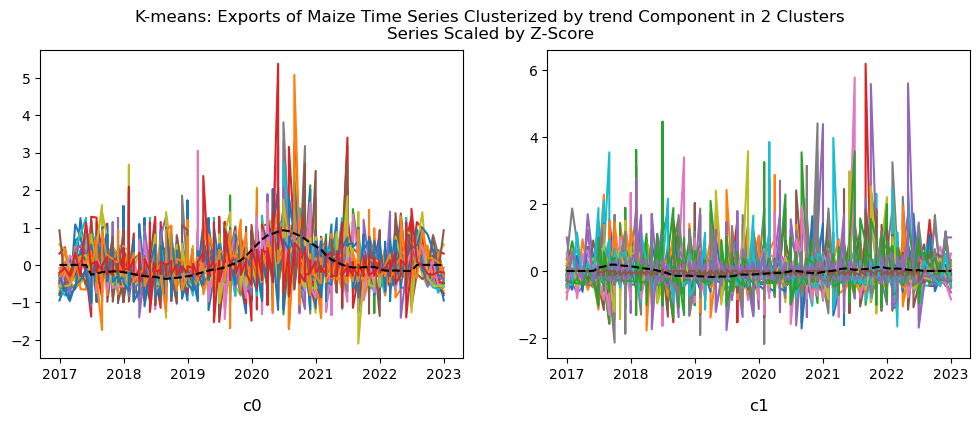

In [15]:
clusterIndex = 0

dfPartnersByCluster = df_base.reset_index()[['partnerCodeISO',newColumns[clusterIndex]]].drop_duplicates().groupby(newColumns[clusterIndex]).agg(partners = ('partnerCodeISO','count')).reset_index().rename(columns = {newColumns[clusterIndex]:'cluster'}).T
dfPartnersByCluster.columns = dfPartnersByCluster[dfPartnersByCluster.index == 'cluster'].values[0]
display(dfPartnersByCluster.iloc[1:,:])

fig = grxClusters_stdDecomp(df = df_timeSeriesDecomp, target = target, flowType = flowType, clusterIndex = clusterIndex)
plt.show()

,0,1,2
partners,27,10,19


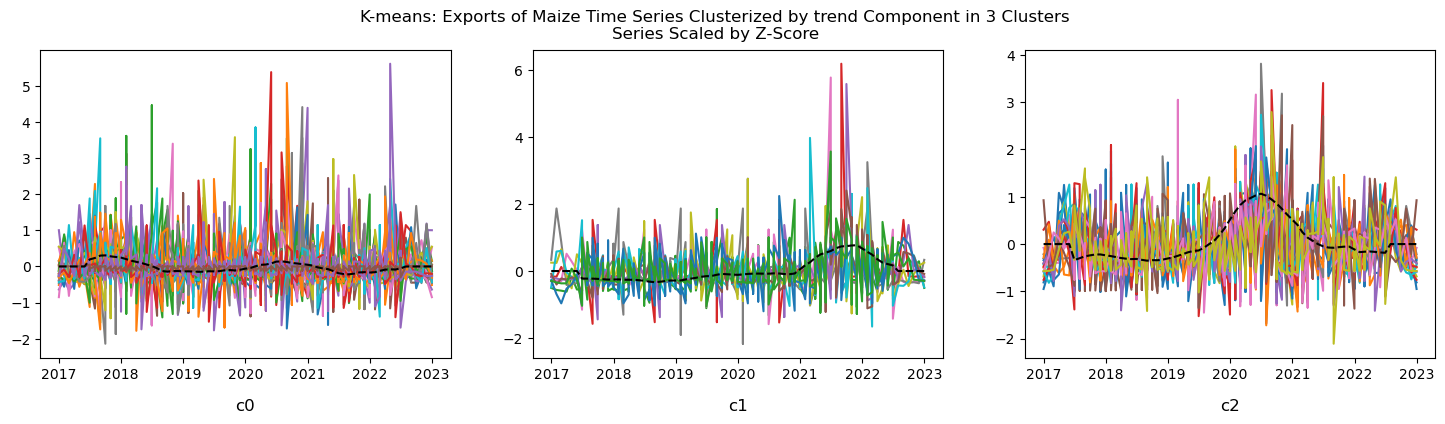

In [16]:
clusterIndex = 1

dfPartnersByCluster = df_base.reset_index()[['partnerCodeISO',newColumns[clusterIndex]]].drop_duplicates().groupby(newColumns[clusterIndex]).agg(partners = ('partnerCodeISO','count')).reset_index().rename(columns = {newColumns[clusterIndex]:'cluster'}).T
dfPartnersByCluster.columns = dfPartnersByCluster[dfPartnersByCluster.index == 'cluster'].values[0]
display(dfPartnersByCluster.iloc[1:,:])

fig = grxClusters_stdDecomp(df = df_timeSeriesDecomp, target = target, flowType = flowType, clusterIndex = clusterIndex)
plt.show()

### 03.00. CLUSTERING BY SEASONAL COMPONENT
#### 03.01. OPTIMAL NUMBER OF CLUSTERS

In [17]:
##-- OPTIMAL CLUSTER NUMBERS
target = 'seasonal'

if target == 'trend':
    df_temp = df_trend.copy()
elif target == 'seasonal':
    df_temp = df_seasonal.copy()
elif target == 'residual':
    df_temp = df_residual.copy()
    
numberOfClusters = pd.DataFrame()    
X = df_temp.drop(columns = ['partnerCodeISO', 'flowType','component', 'cereal']).fillna(0)        

for clusters in range(2,maxClusterNumbers + 1):
    kmeans = KMeans(n_clusters = clusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_

    score_s = silhouette_score(X, labels)
    score_c = calinski_harabasz_score(X, labels)
    score_d = davies_bouldin_score(X, labels)

    numberOfClusters = numberOfClusters.append({'cereal': cereal,
                                                'clusters': clusters,
                                                'silhouetteScore': score_s,
                                                'calinskiHarabaszScore': score_c,
                                                'daviesBouldinScore': score_d,
                                                'flowType':flowType
                                                }, ignore_index = True) 
    
numberOfClusters['maxValueOf_S'] = numberOfClusters['silhouetteScore'] == numberOfClusters['silhouetteScore'].max()
numberOfClusters['maxValueOf_C'] = numberOfClusters['calinskiHarabaszScore'] == numberOfClusters['calinskiHarabaszScore'].max()
numberOfClusters['minValueOf_D'] = numberOfClusters['daviesBouldinScore'] == numberOfClusters['daviesBouldinScore'].min()

del(df_temp)     
    
optimalNumberOfClusters = numberOfClusters[(numberOfClusters['maxValueOf_S']) | (numberOfClusters['maxValueOf_C']) | (numberOfClusters['minValueOf_D'])].reset_index(drop = True)
optimalNumberOfClusters = optimalNumberOfClusters.clusters.unique()
optimalNumberOfClusters

array([2, 3], dtype=int64)

#### 03.02. CLUSTERING BY K-MEANS

In [18]:
##-- DATA (X)
if target == 'trend':
    df_temp = df_trend.copy()
elif target == 'seasonal':
    df_temp = df_seasonal.copy()
elif target == 'residual':
    df_temp = df_residual.copy()
    
X = df_temp.drop(columns = ['partnerCodeISO', 'flowType','component', 'cereal']).fillna(0)   

In [19]:
##--CLUSTERING
Y = X.copy().reset_index()
newColumns = []
#kmeansCenters = pd.DataFrame()

for numClusters in optimalNumberOfClusters:
    clusterTag = f'{numClusters}_clusters{target.title()}'
    
    kmeans = KMeans(n_clusters = numClusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_
    centers = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
    centers['cluster'] = centers.index
    centers['exp'] = clusterTag           
    
    Y[clusterTag] = labels
    centers['partners'] = Y.groupby(clusterTag).size().values ##-PARTNERS BY CLUSTERS
    
    kmeansCenters = kmeansCenters.append(centers).reset_index(drop = True)
    newColumns = np.append(newColumns,clusterTag)
    
    df_base = df_base.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
    df_timeSeriesDecomp = df_timeSeriesDecomp.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
                                  
newColumns

array(['2_clustersSeasonal', '3_clustersSeasonal'], dtype='<U32')

,0,1
partners,27,29


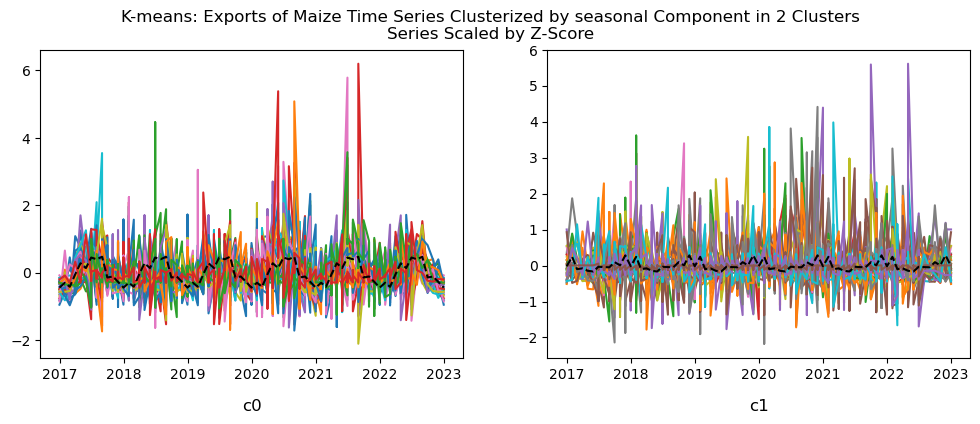

In [20]:
clusterIndex = 0

dfPartnersByCluster = df_base.reset_index()[['partnerCodeISO',newColumns[clusterIndex]]].drop_duplicates().groupby(newColumns[clusterIndex]).agg(partners = ('partnerCodeISO','count')).reset_index().rename(columns = {newColumns[clusterIndex]:'cluster'}).T
dfPartnersByCluster.columns = dfPartnersByCluster[dfPartnersByCluster.index == 'cluster'].values[0]
display(dfPartnersByCluster.iloc[1:,:])

fig = grxClusters_stdDecomp(df = df_timeSeriesDecomp, target = target, flowType = flowType, clusterIndex = clusterIndex)
plt.show()

,0,1,2
partners,15,28,13


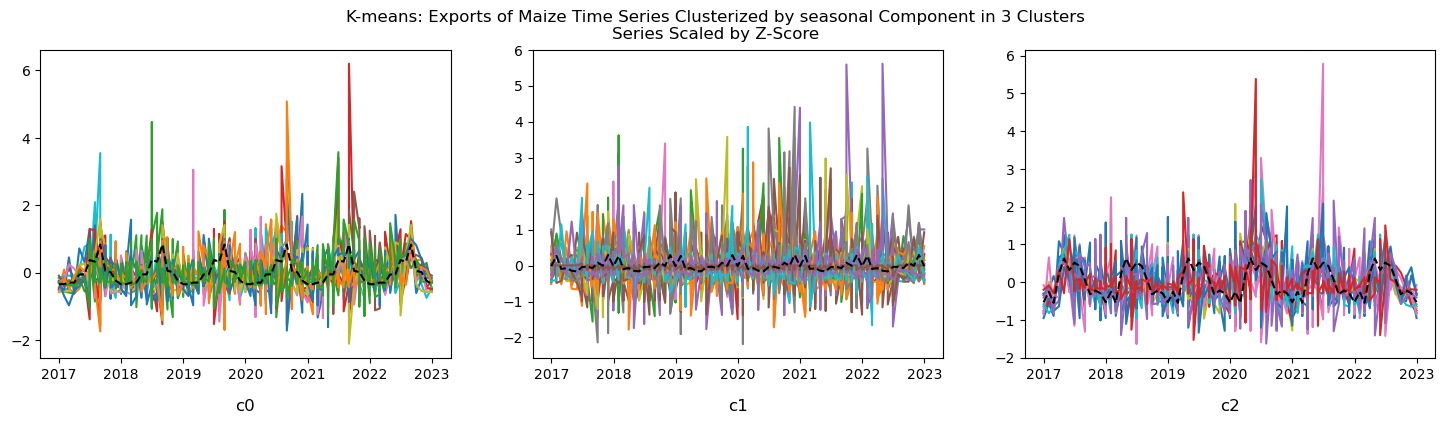

In [21]:
clusterIndex = 1

dfPartnersByCluster = df_base.reset_index()[['partnerCodeISO',newColumns[clusterIndex]]].drop_duplicates().groupby(newColumns[clusterIndex]).agg(partners = ('partnerCodeISO','count')).reset_index().rename(columns = {newColumns[clusterIndex]:'cluster'}).T
dfPartnersByCluster.columns = dfPartnersByCluster[dfPartnersByCluster.index == 'cluster'].values[0]
display(dfPartnersByCluster.iloc[1:,:])

fig = grxClusters_stdDecomp(df = df_timeSeriesDecomp, target = target, flowType = flowType, clusterIndex = clusterIndex)
plt.show()

### 04.00. CLUSTERING BY RESIDUAL COMPONENT
#### 04.01. OPTIMAL NUMBER OF CLUSTERS

In [22]:
##-- OPTIMAL CLUSTER NUMBERS
target = 'residual'

if target == 'trend':
    df_temp = df_trend.copy()
elif target == 'seasonal':
    df_temp = df_seasonal.copy()
elif target == 'residual':
    df_temp = df_residual.copy()
    
numberOfClusters = pd.DataFrame()    
X = df_temp.drop(columns = ['partnerCodeISO', 'flowType','component', 'cereal']).fillna(0)        

for clusters in range(2,maxClusterNumbers + 1):
    kmeans = KMeans(n_clusters = clusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_

    score_s = silhouette_score(X, labels)
    score_c = calinski_harabasz_score(X, labels)
    score_d = davies_bouldin_score(X, labels)

    numberOfClusters = numberOfClusters.append({'cereal': cereal,
                                                'clusters': clusters,
                                                'silhouetteScore': score_s,
                                                'calinskiHarabaszScore': score_c,
                                                'daviesBouldinScore': score_d,
                                                'flowType':flowType
                                                }, ignore_index = True) 
    
numberOfClusters['maxValueOf_S'] = numberOfClusters['silhouetteScore'] == numberOfClusters['silhouetteScore'].max()
numberOfClusters['maxValueOf_C'] = numberOfClusters['calinskiHarabaszScore'] == numberOfClusters['calinskiHarabaszScore'].max()
numberOfClusters['minValueOf_D'] = numberOfClusters['daviesBouldinScore'] == numberOfClusters['daviesBouldinScore'].min()

del(df_temp)     
    
optimalNumberOfClusters = numberOfClusters[(numberOfClusters['maxValueOf_S']) | (numberOfClusters['maxValueOf_C']) | (numberOfClusters['minValueOf_D'])].reset_index(drop = True)
optimalNumberOfClusters = optimalNumberOfClusters.clusters.unique()
optimalNumberOfClusters

array([3, 6], dtype=int64)

#### 04.02. CLUSTERING BY K-MEANS

In [23]:
##-- DATA (X)
if target == 'trend':
    df_temp = df_trend.copy()
elif target == 'seasonal':
    df_temp = df_seasonal.copy()
elif target == 'residual':
    df_temp = df_residual.copy()
    
X = df_temp.drop(columns = ['partnerCodeISO', 'flowType','component', 'cereal']).fillna(0)   

In [24]:
##--CLUSTERING
Y = X.copy().reset_index()
newColumns = []
#kmeansCenters = pd.DataFrame()

for numClusters in optimalNumberOfClusters:
    clusterTag = f'{numClusters}_clusters{target.title()}'
    
    kmeans = KMeans(n_clusters = numClusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_
    centers = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
    centers['cluster'] = centers.index
    centers['exp'] = clusterTag           
    
    Y[clusterTag] = labels
    centers['partners'] = Y.groupby(clusterTag).size().values ##-PARTNERS BY CLUSTERS
    
    kmeansCenters = kmeansCenters.append(centers).reset_index(drop = True)
    newColumns = np.append(newColumns,clusterTag)
    
    df_base = df_base.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
    df_timeSeriesDecomp = df_timeSeriesDecomp.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
                                  
newColumns

array(['3_clustersResidual', '6_clustersResidual'], dtype='<U32')

,0,1,2
partners,15,23,18


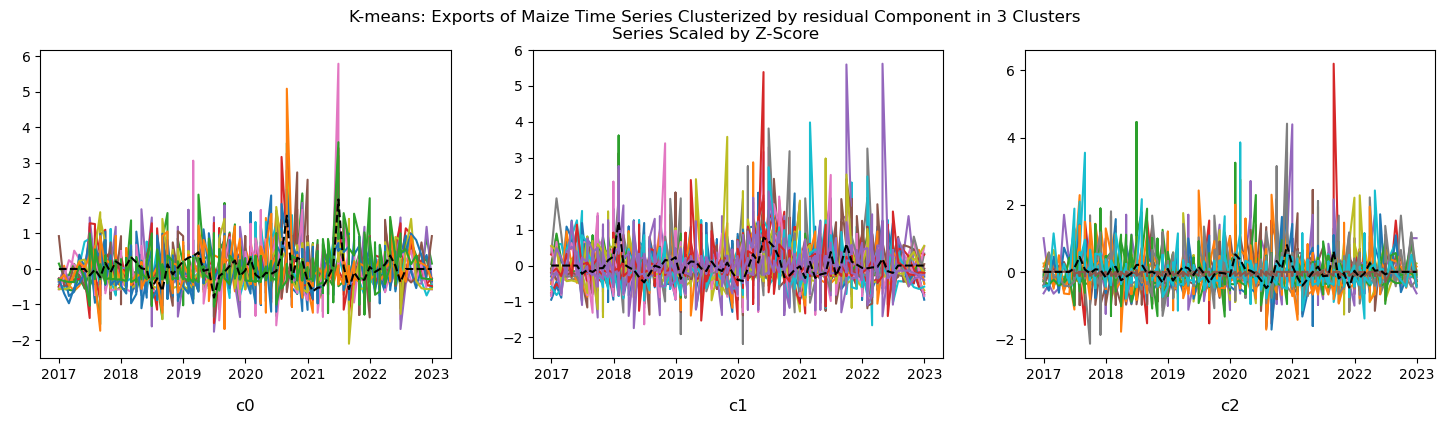

In [25]:
clusterIndex = 0

dfPartnersByCluster = df_base.reset_index()[['partnerCodeISO',newColumns[clusterIndex]]].drop_duplicates().groupby(newColumns[clusterIndex]).agg(partners = ('partnerCodeISO','count')).reset_index().rename(columns = {newColumns[clusterIndex]:'cluster'}).T
dfPartnersByCluster.columns = dfPartnersByCluster[dfPartnersByCluster.index == 'cluster'].values[0]
display(dfPartnersByCluster.iloc[1:,:])

fig = grxClusters_stdDecomp(df = df_timeSeriesDecomp, target = target, flowType = flowType, clusterIndex = clusterIndex)
plt.show()

,0,1,2,3,4,5
partners,6,5,13,20,5,7


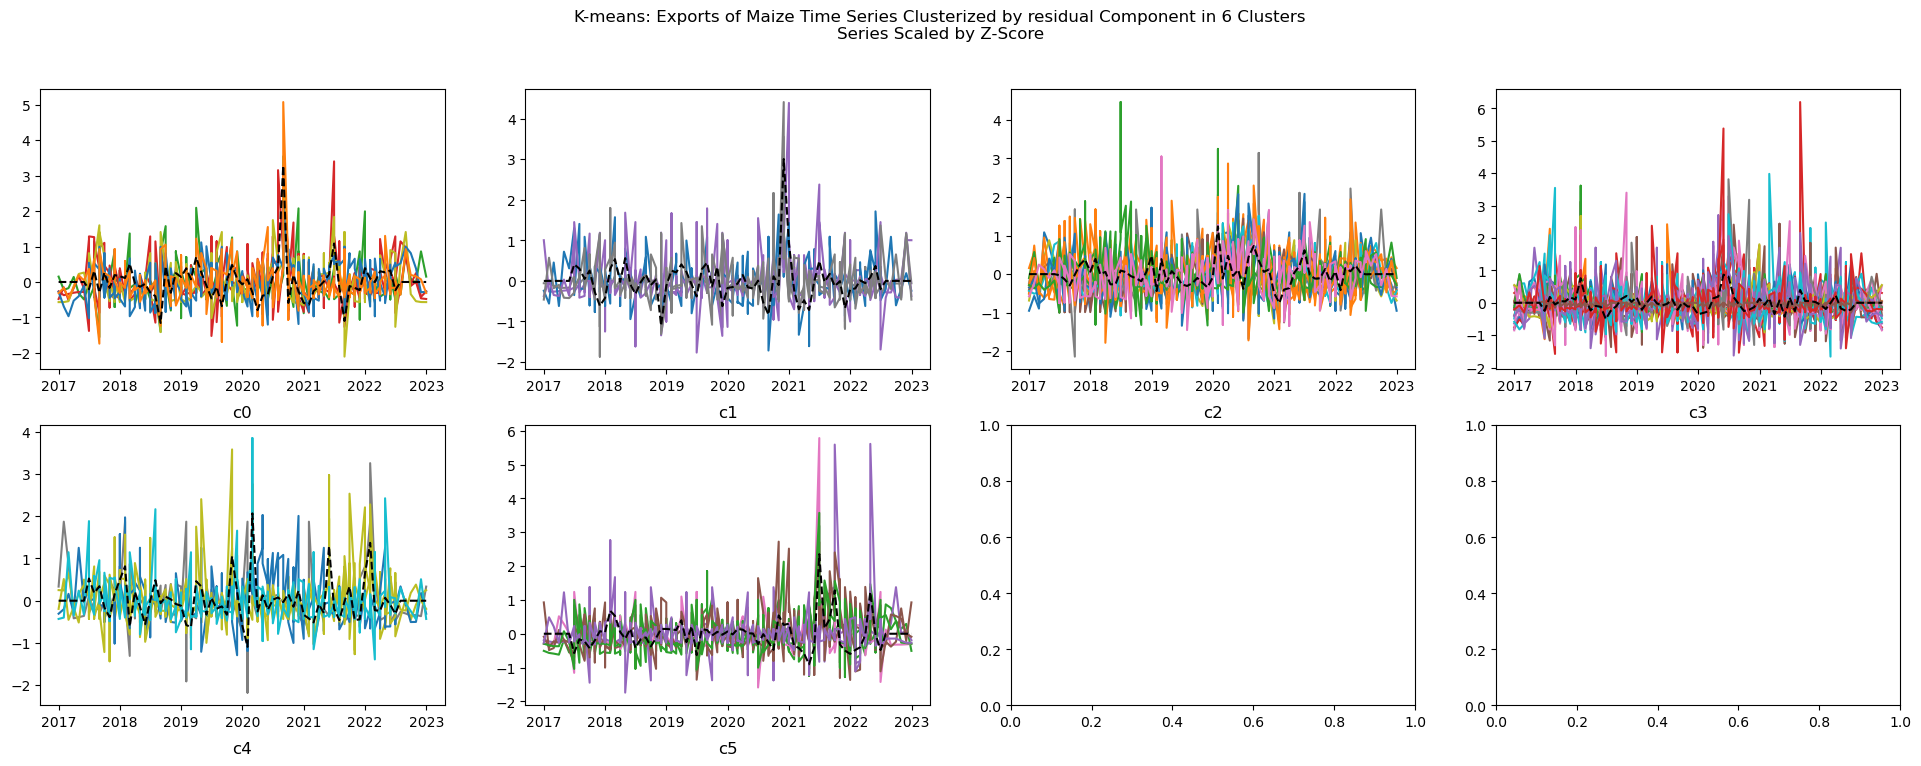

In [26]:
clusterIndex = 1

dfPartnersByCluster = df_base.reset_index()[['partnerCodeISO',newColumns[clusterIndex]]].drop_duplicates().groupby(newColumns[clusterIndex]).agg(partners = ('partnerCodeISO','count')).reset_index().rename(columns = {newColumns[clusterIndex]:'cluster'}).T
dfPartnersByCluster.columns = dfPartnersByCluster[dfPartnersByCluster.index == 'cluster'].values[0]
display(dfPartnersByCluster.iloc[1:,:])

fig = grxClusters_stdDecomp(df = df_timeSeriesDecomp, target = target, flowType = flowType, clusterIndex = clusterIndex)
plt.show()

### 05.00. EXPORT

The results will be exported to be presented in an exploratory dashboard with the other clustering experiments results.

In [27]:
selectedExperiment = ['3_clustersTrend','3_clustersSeasonal','3_clustersResidual']

df_export = df_base[selectedExperiment].reset_index().drop_duplicates().reset_index(drop = True).rename(columns = {selectedExperiment[0]:f'clusterBy{selectedExperiment[0][10:]}Component',
                                                                                                                   selectedExperiment[1]:f'clusterBy{selectedExperiment[1][10:]}Component',
                                                                                                                   selectedExperiment[2]:f'clusterBy{selectedExperiment[2][10:]}Component'})
df_export['cereal'] = cereal
df_export.to_csv(wd + f'/clustersExp03.csv.gz', index = False, sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_export.head()

,partnerCodeISO,clusterByTrendComponent,clusterBySeasonalComponent,clusterByResidualComponent,cereal
0,DZA,2,2,1,Maize
1,CHL,2,0,0,Maize
2,COL,1,0,0,Maize
3,COG,1,0,2,Maize
4,COD,0,1,2,Maize


In [28]:
df_export_centers = kmeansCenters[kmeansCenters['exp'].isin(selectedExperiment)].drop(columns = ['partners']).melt(id_vars = ['cluster','exp']).rename(columns = {'value':f'{flowColumn}_scaledCentroid'})
df_export_centers['cereal'] = cereal
df_export_centers.to_csv(wd + f'/clustersExp03_centers.csv.gz', index = False, sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_export_centers

,cluster,exp,variable,t_exp_scaledCentroid,cereal
0,0,3_clustersTrend,2016-12-31,0.000000,Maize
1,1,3_clustersTrend,2016-12-31,0.000000,Maize
2,2,3_clustersTrend,2016-12-31,0.000000,Maize
3,0,3_clustersSeasonal,2016-12-31,-0.342457,Maize
4,1,3_clustersSeasonal,2016-12-31,-0.015341,Maize
...,...,...,...,...,...
652,1,3_clustersSeasonal,2022-12-31,-0.015341,Maize
653,2,3_clustersSeasonal,2022-12-31,-0.531865,Maize
654,0,3_clustersResidual,2022-12-31,0.000000,Maize
655,1,3_clustersResidual,2022-12-31,0.000000,Maize


In [29]:
#Exporting Base dataset
df_auxClusterA = pd.read_csv(wd + '/clustersExp01.csv.gz', sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_auxClusterB = pd.read_csv(wd + '/clustersExp02.csv.gz', sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])

df_export_base = df_base_copy.merge(df_auxClusterA[['partnerCodeISO','clusterByMetrics']], on = 'partnerCodeISO', how = 'left')
df_export_base = df_export_base.merge(df_auxClusterB[['partnerCodeISO','clusterByTWDs']], on = 'partnerCodeISO', how = 'left')
df_export_base = df_export_base.merge(df_export[['partnerCodeISO','clusterByTrendComponent','clusterBySeasonalComponent','clusterByResidualComponent']], on = 'partnerCodeISO', how = 'left')

df_export_base.rename(columns = {'clusterByTrendComponent':'TREND GROUP',
                                 'clusterBySeasonalComponent':'SEASONAL GROUP',
                                 'clusterByResidualComponent':'RESIDUAL GROUP',
                                 'clusterByMetrics':'METRICS GROUP',
                                 'clusterByTWDs':'SIMILARITY GROUP'}, inplace = True)

df_export_base.to_csv(wd + f'/df_baseWithClusters.csv.gz', index = False, sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])

In [30]:
df_export_base.head()

,calendarCode,date,t_exp,reporterCodeISO,reporterDesc,partnerCodeISO,partnerDesc,partnerRegionDesc,desc_l2,t_imp,METRICS GROUP,SIMILARITY GROUP,TREND GROUP,SEASONAL GROUP,RESIDUAL GROUP
0,201612,2016-12-31,2000.00,ARG,Argentina,BDI,Burundi,Africa,Wheat,0.0,NaN,NaN,NaN,NaN,NaN
1,201612,2016-12-31,152340.00,ARG,Argentina,DZA,Algeria,Africa,Wheat,0.0,5.0,1.0,2.0,2.0,1.0
2,201612,2016-12-31,182860.99,ARG,Argentina,DZA,Algeria,Africa,Maize,0.0,5.0,1.0,2.0,2.0,1.0
3,201612,2016-12-31,208.00,ARG,Argentina,CMR,Cameroon,Africa,Maize,0.0,4.0,NaN,NaN,NaN,NaN
4,201612,2016-12-31,83.97,ARG,Argentina,CAN,Canada,North America,Rice,0.0,0.0,NaN,NaN,NaN,NaN
